In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers, losses

print(tf.__version__)

2022-11-22 17:10:24.395794: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-22 17:10:24.470341: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-22 17:10:24.473545: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-22 17:10:24.473554: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

2.10.0


We'll use the Large Movie Review Dataset that contains the text of 50,000 movie reviews from the Internet Movie Database. These are split into 25,000 reviews for training and 25,000 reviews for testing. The training and testing sets are balanced, meaning they contain an equal number of positive and negative reviews.

## Download and explore the IMDB dataset

In [2]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                 untar=True, cache_dir='.',
                                 cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

In [3]:
print(os.listdir(dataset_dir))

['imdbEr.txt', 'README', 'train', 'imdb.vocab', 'test']


In [4]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['labeledBow.feat',
 'pos',
 'urls_unsup.txt',
 'neg',
 'urls_pos.txt',
 'unsupBow.feat',
 'urls_neg.txt',
 'unsup']

The `aclImdb/train/pos` and `aclImdb/train/neg` directories contain many test files, each of which is a single movie review

In [5]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
    print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


## Load the dataset
Load the data off disk and prepare it into a format suitable for training using `text_dataset_from_directory` utility, which expects a directory structure as follows:
<br><br>
*main_directory/<br>
...class_a/<br>
......a_text_1.txt<br>
......a_text_2.txt<br>
...class_b/<br>
......b_text_1.txt<br>
......b_text_2.txt*<br>

To prepare a dataset for binary classification, we need two folders on disk, for the positive and the negative movie reviews found in `aclImdb/train/pos` and `aclImdb/train/neg` and the additional folders will be removed before using the utility

In [6]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

Now we will use the `text_dataset_from_directory` utility to create a labeled `tf.data.Dataset`, a powerful collection of tools for working with data<br><br>
When running a machine learning experiment, it is a best practice to divide your dataset into three splits: `train`, `validation`, and `test`<br><br>
Train and test set are already available so we'll create a validation set using an 80:20 split of the training data by using the `validation_split` argument

In [7]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory('aclImdb/train',
                                                         batch_size=batch_size,
                                                         validation_split=0.2,
                                                         subset='training',
                                                         seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


2022-11-22 17:10:38.685554: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-22 17:10:38.685568: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-22 17:10:38.685578: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (nsl54): /proc/driver/nvidia/version does not exist
2022-11-22 17:10:38.685759: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print("Review", text_batch.numpy()[i])
        print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

In [9]:
raw_train_ds.class_names

['neg', 'pos']

In [10]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [11]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory('aclImdb/train',
                                                       batch_size=batch_size,
                                                       validation_split=0.2,
                                                       subset='validation',
                                                       seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [12]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory('aclImdb/test',
                                                        batch_size=batch_size)

Found 25000 files belonging to 2 classes.


## Prepare dataset for training
Standerdize, tokenize and vectorize the data using `tf.keras.layers.TextVectorization` layer
- **Standardization** is preprocessing the text typically to remove punctuation or HTML elements
- **Tokenization** is splitting strings into tokens
- **Vetorization** is converting tokens into numbers so they can be fed to a neural network

In [13]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,
                                   '[%s]' % re.escape(string.punctuation),
                                   '')

In [14]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(standardize=custom_standardization,
                                          max_tokens=max_features,
                                          output_mode='int',
                                          output_sequence_length=sequence_length)

In [15]:
train_text = raw_train_ds.map(lambda x,y:x)
vectorize_layer.adapt(train_text)

In [16]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [17]:
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  86,   17,  260,    2,  222,    1,  571,   31,  229,   11, 2418,
           1,   51,   22,   25,  404,  251,   12,  306,  282,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       

We can lookup the token (string) that each integer corresponds to by calling `.get_vocabulary()` on the layer

In [18]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


In [19]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

## Configure the dataset for performance
- `.cache()` keeps data in memory after it's loaded off disk and ensure the dataset does not become a bottleneck whil running the model. This method can be used for datasets too large to fit into memory. This is much more efficient than reading many small files.
- `.prefetch()` overlaps data preprocessing and model execution while training.

In [20]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Create the model

In [21]:
embedding_dim = 16

In [22]:
model = tf.keras.Sequential([layers.Embedding(max_features+1, embedding_dim),
                            layers.Dropout(0.2),
                            layers.GlobalAveragePooling1D(),
                            layers.Dropout(0.2),
                            layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
__________________________________________________

1. **Embedding** layer takes the integer-encoded reviews and looks up an embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: (batch, sequence, embedding).
2. **GlobalAveragePooling1D** layer returns a fixed length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.
3. This fixed-length output vector is piped through a fully-connected **Dense** layer with 16 hidden units.
4. The last layer is densely connected with a single output node.

## Loss function and optimizer


In [23]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
             optimizer='adam',
             metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

## Train

In [24]:
epochs = 30
history = model.fit(train_ds,
                   validation_data=val_ds,
                   epochs=epochs)

Epoch 1/30
625/625 [==============================] - 2s 2ms/step - loss: 0.6627 - binary_accuracy: 0.7000 - val_loss: 0.6134 - val_binary_accuracy: 0.7714
Epoch 2/30
625/625 [==============================] - 1s 2ms/step - loss: 0.5473 - binary_accuracy: 0.8028 - val_loss: 0.4973 - val_binary_accuracy: 0.8246
Epoch 3/30
625/625 [==============================] - 1s 2ms/step - loss: 0.4432 - binary_accuracy: 0.8467 - val_loss: 0.4194 - val_binary_accuracy: 0.8474
Epoch 4/30
625/625 [==============================] - 1s 2ms/step - loss: 0.3784 - binary_accuracy: 0.8654 - val_loss: 0.3735 - val_binary_accuracy: 0.8608
Epoch 5/30
625/625 [==============================] - 1s 2ms/step - loss: 0.3342 - binary_accuracy: 0.8787 - val_loss: 0.3447 - val_binary_accuracy: 0.8682
Epoch 6/30
625/625 [==============================] - 1s 2ms/step - loss: 0.3051 - binary_accuracy: 0.8891 - val_loss: 0.3258 - val_binary_accuracy: 0.8724
Epoch 7/30
625/625 [==============================] - 1s 2ms/ste

## Evaluate

In [25]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 1s 936us/step - loss: 0.4190 - binary_accuracy: 0.8559
Loss:  0.4190451502799988
Accuracy:  0.8558800220489502


## Plot of accuracy and loss over time

In [26]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

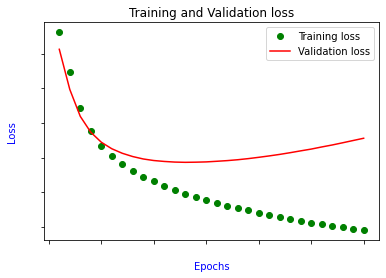

In [27]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, loss, 'go', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and Validation loss')
plt.xlabel('Epochs', color='blue')
plt.ylabel('Loss', color='blue')
plt.xticks(color='white')
plt.yticks(color='white')
plt.legend()

plt.show()

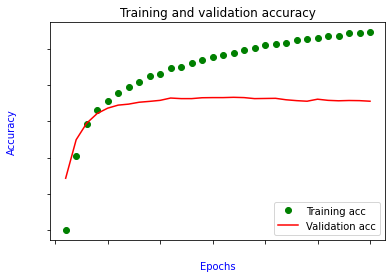

In [28]:
plt.plot(epochs, acc, 'go', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs', color='blue')
plt.ylabel('Accuracy', color='blue')
plt.xticks(color='white')
plt.yticks(color='white')
plt.legend(loc='lower right')

plt.show()

We can clearly see how the model overfits to the training dataset. For this particular case, we could prevent overfitting by simply stopping the training when the validation accuracy is no longer increasing. One way to do so is to use the `tf.keras.callbacks.EarlyStopping` callback.

## Export the model
We can include the `TextVectorization` layer inside the model to make the model capable of processing raw strings

In [29]:
export_model = tf.keras.Sequential([
    vectorize_layer,
    model,
    layers.Activation('sigmoid')
])

export_model.compile(loss=losses.BinaryCrossentropy(from_logits=False), optimizer='adam', metrics=['accuracy'])

loss, accuracy = export_model.evaluate(raw_test_ds)
accuracy

782/782 [==============================] - 1s 1ms/step - loss: 0.4190 - accuracy: 0.8559


0.8558800220489502

## inference on new data

In [30]:
examples = [
    "The movie was great!",
    "The movie was okay.",
    "The movie was terrible..."
]

export_model.predict(examples)

1/1 [==============================] - 0s 73ms/step


array([[0.6812249 ],
       [0.36956483],
       [0.26546416]], dtype=float32)